## Loading data

In [398]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import binarize
warnings.filterwarnings('ignore')

In [386]:
DATA_DIR = './data_earth/'

In [387]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annot')

In [388]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color = 'white')
        plt.imshow(image)
    plt.show()

### Dataloader

In [389]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [390]:
class Dataset(BaseDataset):
    """OIL Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'oil']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
#         print(self.images_fps[i])
#         print(self.masks_fps[i])
#         print(image.shape)
#         print(mask.shape)
        _, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        mask = mask//255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

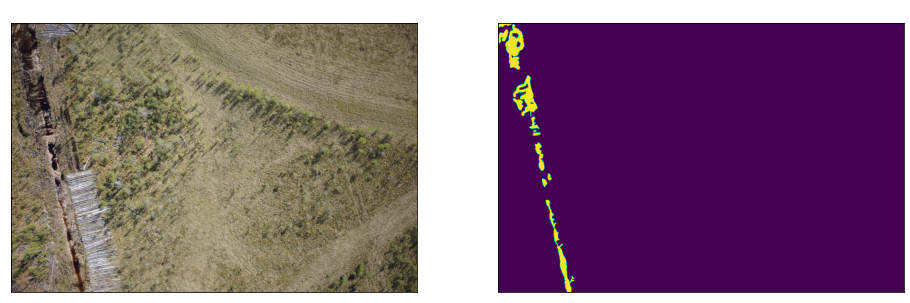

In [391]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['oil'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    oil_mask=mask.squeeze(),
)

### Augmentations

In [392]:
import albumentations as albu

In [393]:
def get_training_augmentation():
    train_transform = [
        albu.augmentations.geometric.resize.LongestMaxSize (max_size=640, interpolation=1, always_apply=False, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.augmentations.transforms.GaussNoise(p=0.2),
        albu.augmentations.geometric.transforms.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.augmentations.transforms.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.augmentations.geometric.resize.LongestMaxSize (max_size=640, interpolation=1, always_apply=False, p=1),
        albu.PadIfNeeded(min_height=470, min_width=640, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(320, 320, 1)


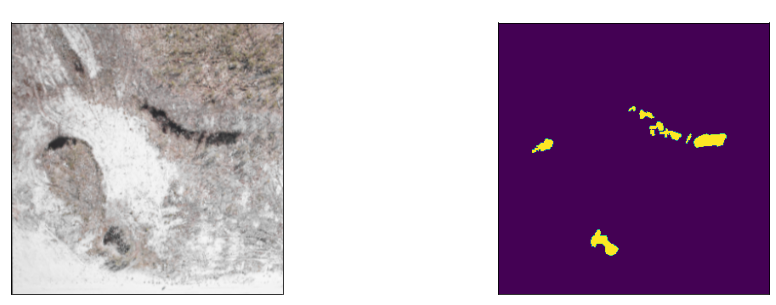

(320, 320, 1)


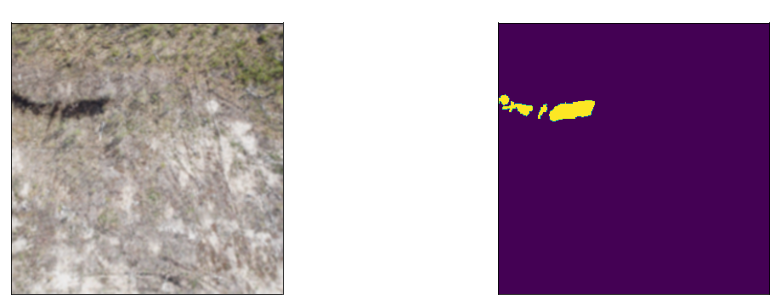

(320, 320, 1)


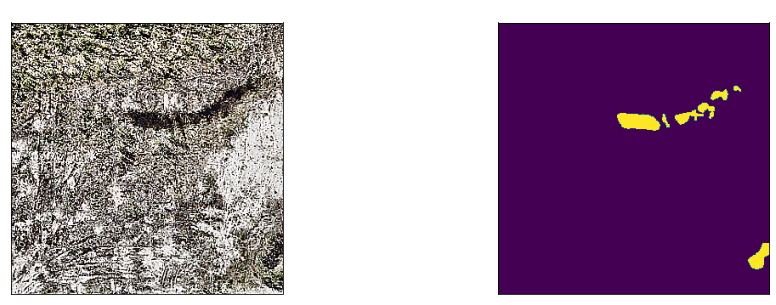

In [394]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['oil'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    print(mask.shape)
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [319]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [347]:
ENCODER = 'timm-efficientnet-b1'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['oil']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [348]:
model.encoder.conv_stem = torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [349]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [350]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [351]:
next(iter(train_loader))[0].shape

torch.Size([8, 3, 320, 320])

In [352]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [353]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, dice_loss - 0.9092, iou_score - 0.02637]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, dice_loss - 0.8941, iou_score - 0.04429]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s, dice_loss - 0.9152, iou_score - 0.03992]

Epoch: 3
valid: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s, dice_loss - 0.8943, iou_score - 0.06372]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s, dice_loss - 0.8895, iou_score - 0.08906]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, dice_loss - 0.8863, iou_score - 0.08814]

Epoch: 6
valid: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s, dice_loss - 0.9011, iou_score - 0.07615]

Epoch: 7
valid: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s, dice_loss - 0.8893, iou_score - 0.07738]

Epoch: 8
valid: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, dice_loss - 0.8906, iou_score - 0.07624]

Epoch: 9
va

## Test best saved model

In [357]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [358]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [359]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s, dice_loss - 0.3586, iou_score - 0.5464]


## Visualize predictions

In [360]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

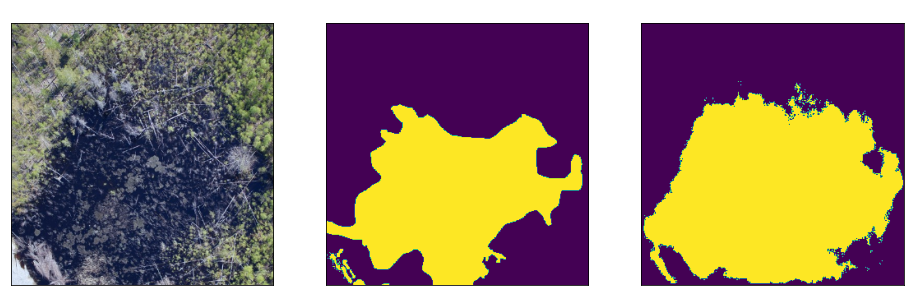

In [423]:
for i in range(1):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    pr_mask = np.ravel(binarize(pr_mask.reshape(1,-1), 0.9))
    pr_mask = pr_mask.reshape(gt_mask.shape)
    image = image - np.amin(image)
    image = image/np.amax(image)
    visualize(
        drone_image=image.transpose((1, 2, 0)), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [424]:
np.unique(pr_mask, return_counts=True)

(array([0., 1.], dtype=float32), array([50702, 51698], dtype=int64))

In [425]:
SQUARE_ONE_PIX = 0.010625
oil_square = SQUARE_ONE_PIX * pr_mask.sum()

In [413]:
print(f'Площадь розлива: {oil_square:.2f} м. кв.')

Площадь розлива: 537.25 м. кв.
